# Your first RAG application

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import rich
from IPython.display import Image, display

In [ ]:
# Install ollama to serve the models 
!curl https://ollama.ai/install.sh | sh
!ollama --version

In [ ]:
# Start ollama serve in the background using nohup and &
!nohup ollama serve > /dev/null 2>&1 &

In [ ]:
# Obtain your embedding & LLM models (execute here or go to terminal)
!ollama pull mxbai-embed-large
!ollama pull mistral  

In [3]:
# Check model availability 
!ollama list

NAME                        ID              SIZE      MODIFIED               
mistral:latest              f974a74358d6    4.1 GB    Less than a second ago    
mxbai-embed-large:latest    468836162de7    669 MB    Less than a second ago    


In [4]:
import ollama 

# First run 
res = ollama.chat(model="mistral", 
            messages=[ {"role": "user", "content": "Tell me a joke about Data Science"}]
           )
rich.print(res)

ChatResponse(
    model='mistral',
    created_at='2025-05-09T21:09:48.272958Z',
    done=True,
    done_reason='stop',
    total_duration=3841317042,
    load_duration=18032875,
    prompt_eval_count=12,
    prompt_eval_duration=2083972542,
    eval_count=35,
    eval_duration=1737818208,
    message=Message(
        role='assistant',
        content=' Why was the data scientist afraid to go to the beach?\n\nBecause he heard there were high-tides 
and low-tides, but no median tide!',
        images=None,
        tool_calls=None
    )
)

# Build a naive RAG pipeline

The main components of a naive RAG pipeline are: 

1. Will use an open-source embedding function
2. ChromaDB to store all the generated documents and index
3. Dense retrieval (semantic search) over the index to retrieve the most relevant content
4. Augment the query with the retrieved context
5. Generate an answer to the query, using the retrieved context  

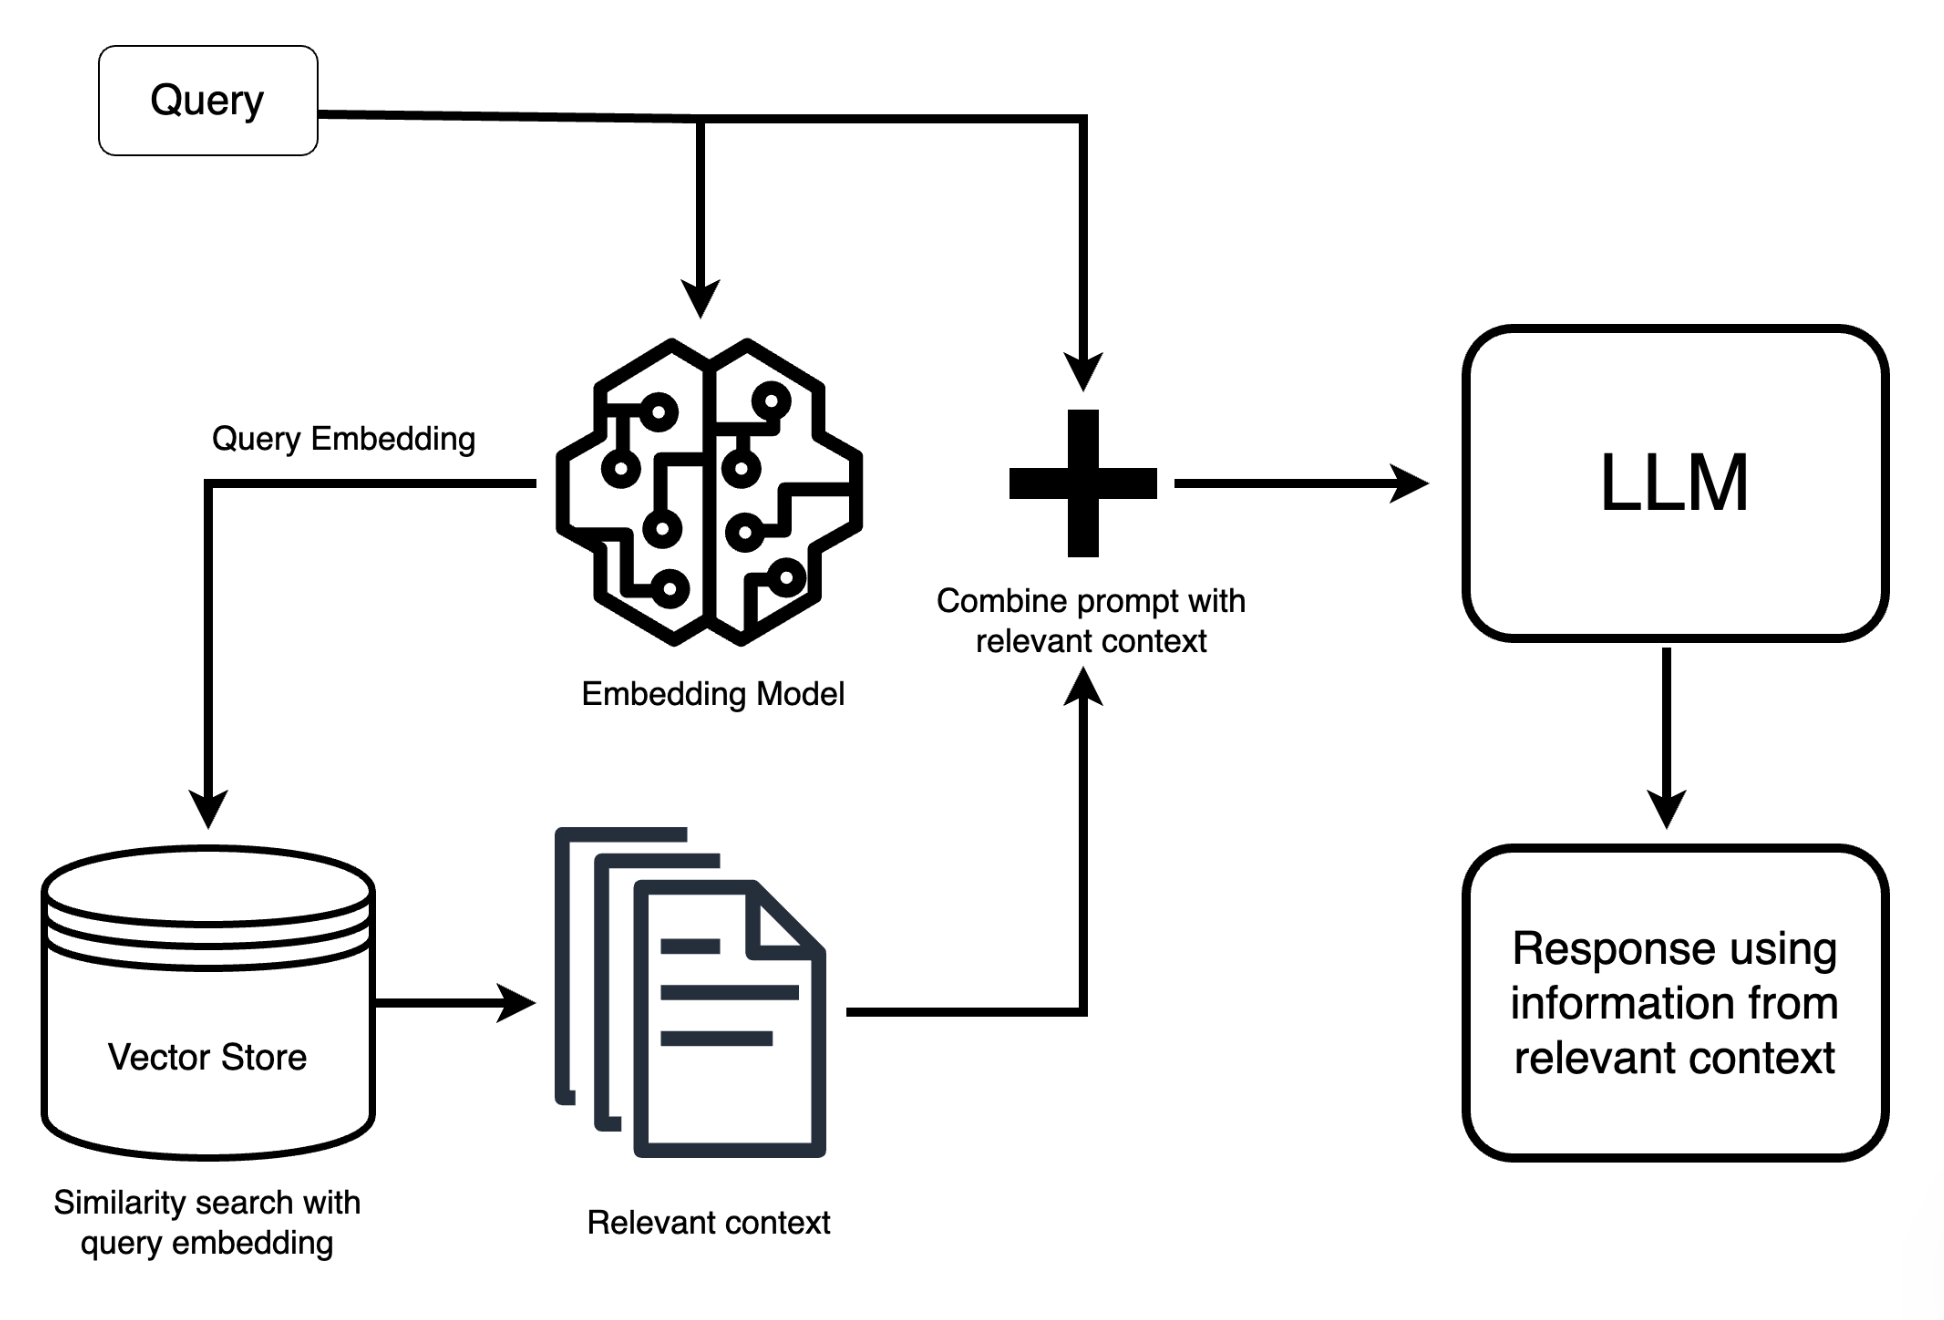

In [35]:
display(Image(filename='../docs/images/rag_diagram.png', width=700))

## Set up your first RAG pipeline

The index is created with all the (chunked) documents + the embedding function 

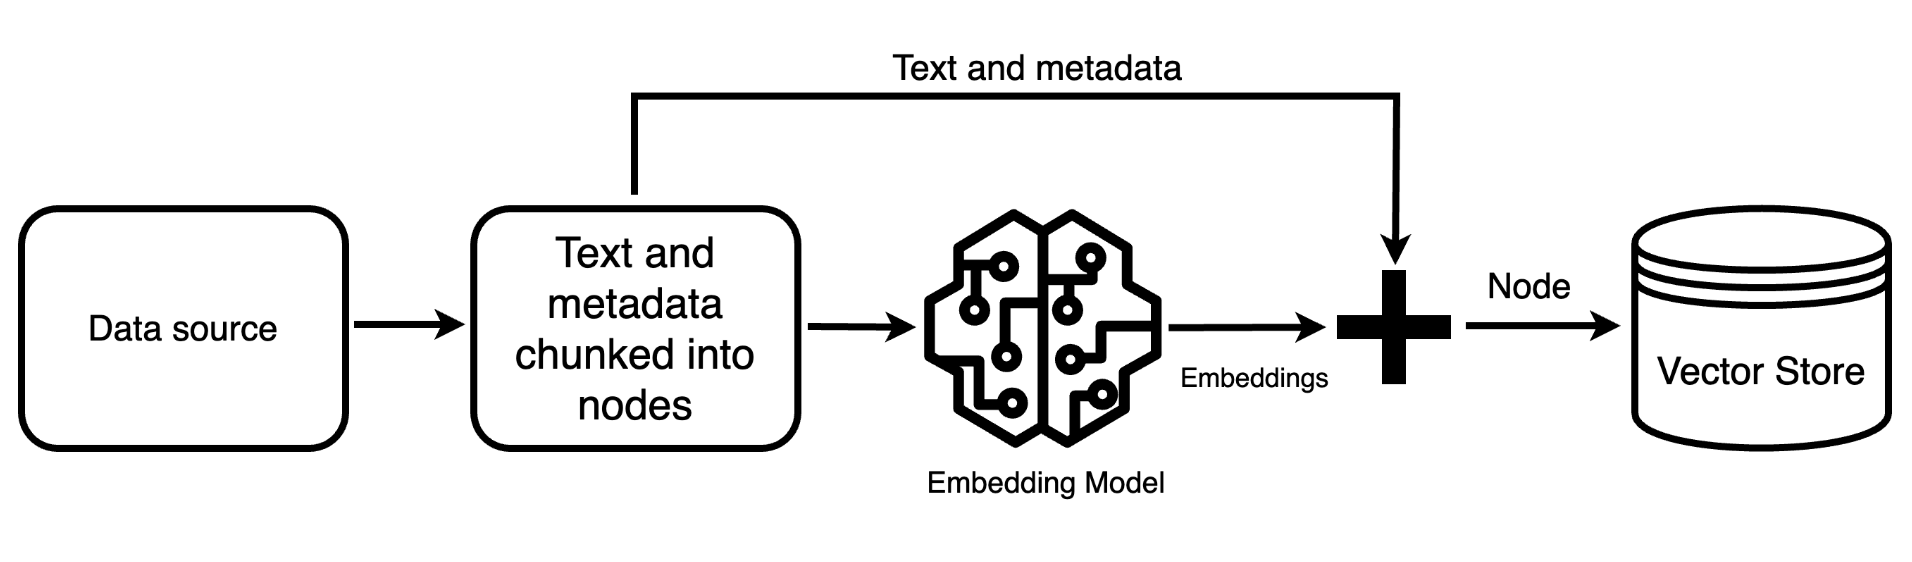

In [38]:
# Show image inline in the notebook
display(Image(filename='../docs/images/indexing.png', width=800))

In [5]:
import os
import ollama
import chromadb
from chromadb.utils.embedding_functions import DefaultEmbeddingFunction

In [6]:
# === Step 1: Setup ChromaDB ===
chroma_client = chromadb.Client()
collection    = chroma_client.get_or_create_collection(name="rag-docs")

In [7]:
# === Step 2: Load and Embed Documents ===
def embed_text(text):
    response = ollama.embed(model="mxbai-embed-large", input=text)
    return response["embeddings"][0]

In [8]:
# Sample docs (could also read from files)
documents = [
    "Jurgen Klopp was born in Germany in 1974. He has been a successful coach in the UK",
    "You can contact Sky customer support through the help portal or live chat.",
    "An apple a day keeps the doctor away"
]

In [9]:
for i, doc in tqdm(enumerate(documents)):
    embedding = embed_text(doc)
    collection.add( documents=[doc],
                    embeddings=[embedding],
                    ids=[f"doc-{i}"]
                    )

0it [00:00, ?it/s]

In [10]:
# === Step 3: Accept User Query and Retrieve Relevant Docs ===
query = "What team did Jurgen Klopp coach?"

query_embedding = embed_text(query)
results = collection.query(query_embeddings=[query_embedding], n_results=3)

rich.print(results) 

{
    'ids': [['doc-0', 'doc-1', 'doc-2']],
    'embeddings': None,
    'documents': [
        [
            'Jurgen Klopp was born in Germany in 1974. He has been a successful coach in the UK',
            'You can contact Sky customer support through the help portal or live chat.',
            'An apple a day keeps the doctor away'
        ]
    ],
    'uris': None,
    'included': ['metadatas', 'documents', 'distances'],
    'data': None,
    'metadatas': [[None, None, None]],
    'distances': [[0.3585015535354614, 1.367884874343872, 1.476802945137024]]
}

In [11]:
retrieved_docs = results["documents"][0]
context = "\n".join(retrieved_docs)

In [12]:
# === Step 4: Run RAG Prompt through Ollama LLM ===
answer_prompt = """You're a personal assistant. Your task is to answer questions using only the provided context. 
If you can not explicitly extract the answer from the context, your answer must be I cannot help with that. 

Question: {query}

<context> 
{context}
</context>

Answer:"""

rich.print(answer_prompt)

You're a personal assistant. Your task is to answer questions using only the provided context. 
If you can not explicitly extract the answer from the context, your answer must be I cannot help with that. 

Context: {context}

Question: {query}

Answer:

In [13]:
query = 'What team did Jurgen Klopp coach?'

In [14]:
res = ollama.chat(model="mistral", 
            messages=[ {"role": "user", "content": answer_prompt.format(context=context, query=query)}]
           )
rich.print(res)

ChatResponse(
    model='mistral',
    created_at='2025-05-09T21:09:51.797249Z',
    done=True,
    done_reason='stop',
    total_duration=2413314750,
    load_duration=5100084,
    prompt_eval_count=119,
    prompt_eval_duration=1044261958,
    eval_count=26,
    eval_duration=1363386833,
    message=Message(
        role='assistant',
        content=' I cannot help with that, as the provided context does not specify which team Jurgen Klopp coached
in the UK.',
        images=None,
        tool_calls=None
    )
)

## Build a proper index 

1. Take large documents and chunk them if needed
2. Add relevant metadata to the documents to enhance search
3. Embed and add to the collection 

In [15]:
# 40,000 lines of Shakespeare from a variety of Shakespeare's plays
with open('../data/shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = text[:100000]

In [16]:
# Naive splitter 
def chunk_text(text, chunk_size, overlap=20):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start = end - overlap  # move back by `overlap` characters
    return chunks

chunks = chunk_text( text, chunk_size=2000, overlap=200 )
print( f'The split method produced {len(chunks)} chunks' )

The split method produced 56 chunks


In [17]:
shakespeare_collection = chroma_client.get_or_create_collection(name="shakespeare-chunks")

i=0
for chunk in tqdm(chunks): 
    embedding = embed_text(chunk)
    shakespeare_collection.add( documents=[chunk],
                    embeddings=[embedding],
                    ids=[f"{i}"]
                    )
    i+=1

  0%|          | 0/56 [00:00<?, ?it/s]

## Generate a valid set of questions so I can evaluate the Retrieval & Generation

Idea is simple: by extracting the questions from passages:
- I can keep track of the origin 
- I can set up an evaluation method for retrieval efficacy. 

In [18]:
summary_prompt = """You are an expert Shakespeare analyst. You will receive a chunk of one of his books, and your task is to summarise what is happening in the passage.
Write a short summary capturing the most relevant information of the passage in less than 100 words. 

Chunk: {chunks}

Answer: 
"""

question_prompt = """You are an expert Shakespeare analyst. You will receive a summary of a passage of one of his books. 
Your task is to generate ONE simple, short, fact-based question that can be answered with the provided text alone. 

You must not mention that you are extracting the question from a text, a passage or a chunk.

Text: {summary}

Question: 
"""

rich.print(f' "SUMMARY_PROMPT" = {summary_prompt}')
rich.print('------------')
rich.print(f' "QUESTION_PROMPT" = {question_prompt}')

"SUMMARY_PROMPT" = You are an expert Shakespeare analyst. You will receive a chunk of one of his books, and your 
task is to summarise what is happening in the passage.
Write a short summary capturing the most relevant information of the passage in less than 100 words. 

Chunk: {chunks}

Answer:

------------

"QUESTION_PROMPT" = You are an expert Shakespeare analyst. You will receive a summary of a passage of one of his 
books. 
Your task is to generate ONE simple, short, fact-based question that can be answered with the provided text alone. 

You must not mention that you are extracting the question from a text, a passage or a chunk.

Text: {summary}

Question:

In [19]:
def extract_question(chunks, chunk_id, verbose=False): 

    # Extract a summary from the provided passage
    summary = ollama.chat(model="mistral", messages=[
    {"role": "user", "content": summary_prompt.format(chunks=chunks[chunk_id])}
    ])

    if verbose:
        rich.print( f'Summary from chunk {chunk_id}: {summary["message"]["content"]}')

    # Extract question from the generated summary 
    question = ollama.chat(model="mistral", messages=[
    {"role": "user", "content": question_prompt.format(summary=summary["message"]["content"])}
    ])

    question = question["message"]["content"]
    rich.print( f'Question from chunk {chunk_id}: {question}')

    return question 

In [20]:
question = extract_question( chunks, 1, verbose=True )

Summary from chunk 1:  A group of citizens, angered by food scarcity and believing the senate to be the cause, rise
up in rebellion against the ruling patricians. Menenius Agrippa, a nobleman known for his sympathy towards the 
people, intervenes, trying to persuade them that their suffering is due to divine intervention rather than the 
senate's greed. The citizens, however, accuse the senate of exploiting them and worsening their condition through 
usury laws and disregard for their welfare. Agrippa warns them against false accusations or folly in their 
uprising.

Question from chunk 1:  Who does Menenius Agrippa believe is responsible for the food scarcity according to the 
text?

In [21]:
chunk_ids = [1,20,35,42,48]
questions = []

for chunk_id in tqdm(chunk_ids):
    question = extract_question( chunks, chunk_id )
    questions.append(question)

question_set = pd.DataFrame( {'chunk_id':chunk_ids, 'question': questions} )

  0%|          | 0/5 [00:00<?, ?it/s]

Question from chunk 1:  Who do the people of Rome accuse as being responsible for the famine in their city?

Question from chunk 20:  Who does Menenius accuse of being impulsive in "The Tragedy of Coriolanus"?

Question from chunk 35:  Who does Sicinius advise Brutus not to revoke as consul in "Julius Caesar"?

Question from chunk 42:  Who or what group in "Coriolanus" demands that Coriolanus be taken to the Tarpeian rock 
and thrown to his death?

Question from chunk 48:  Did Coriolanus willingly agree to flatter the citizens for his political campaign?

# Retrieval 

In [22]:
k = 20 

def find_position(lst, value):
    try:
        return lst.index(value)
    except ValueError:
        return np.nan

In [23]:
found = []
retrieved_chunks = []
for idx in tqdm(question_set.index):
    q   = question_set.at[idx, 'question'] 
    cid = question_set.at[idx, 'chunk_id'] 

    query_embedding = embed_text(q)
    results         = shakespeare_collection.query(query_embeddings=[query_embedding], n_results=k)

    retrieved_chunks.append( results['ids'][0] )
    found.append( find_position( results['ids'][0], str(cid) ) )

question_set['retrieval_rank']   = found 
question_set['retrieved_chunks'] = retrieved_chunks

  0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
# Retrieval results 
question_set

,chunk_id,question,retrieval_rank,retrieved_chunks
0,1,Who do the people of Rome accuse as being res...,0,"[1, 53, 4, 44, 37, 40, 42, 3, 39, 52, 51, 16, ..."
1,20,Who does Menenius accuse of being impulsive i...,14,"[47, 46, 39, 51, 40, 29, 44, 28, 37, 38, 48, 4..."
2,35,Who does Sicinius advise Brutus not to revoke...,6,"[25, 36, 42, 51, 52, 38, 35, 45, 44, 7, 39, 34..."
3,42,"Who or what group in ""Coriolanus"" demands tha...",1,"[52, 42, 51, 39, 37, 53, 46, 28, 18, 29, 43, 1..."
4,48,Did Coriolanus willingly agree to flatter the...,17,"[33, 51, 30, 38, 32, 29, 42, 26, 40, 37, 39, 4..."


Text(0, 0.5, 'Precision')

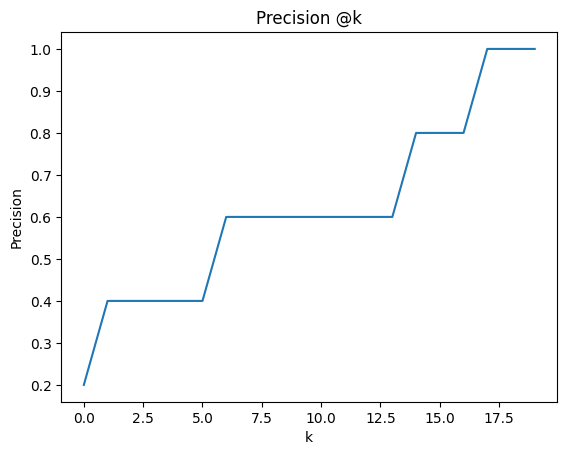

In [25]:
import matplotlib.pyplot as plt

ranks     = range(0,k)
precision = [ (question_set['retrieval_rank']<=rk).mean() for rk in ranks ]

plt.title( 'Precision @k' )
plt.plot( ranks, precision )
plt.xlabel( 'k' )
plt.ylabel( 'Precision' )

# Augment & Generate

In [26]:
top_k     = 5
synthesis = []

for idx in tqdm(question_set.index):

    question = question_set.at[idx, 'question']
    context  = "\n".join( [ chunks[int(cid)] for cid in question_set.at[idx, 'retrieved_chunks'][:top_k] ] )

    response = ollama.chat(model="mistral", messages=[
    {"role": "user", "content": answer_prompt.format( context=context, query=question ) }
])
    answer = response["message"]["content"]
    rich.print( f' "Query": {question} \n "Answer": {answer}' )
    synthesis.append( answer )

question_set['Responses'] = synthesis 

  0%|          | 0/5 [00:00<?, ?it/s]

"Query":  Who do the people of Rome accuse as being responsible for the famine in their city? 
 "Answer":  The people of Rome accuse Consul Coriolanus as being responsible for the famine in their city, even 
though it was actually caused by external factors such as a war with the Volsces.

"Query":  Who does Menenius accuse of being impulsive in "The Tragedy of Coriolanus"? 
 "Answer":  Menenius does not directly accuse anyone of being impulsive in "The Tragedy of Coriolanus". The 
character who is frequently accused of being impulsive or overly passionate is Coriolanus himself. However, 
Menenius serves as a voice of reason and temperance in the play, often trying to moderate the heated exchanges 
between Coriolanus and the common people.

"Query":  Who does Sicinius advise Brutus not to revoke as consul in "Julius Caesar"? 
 "Answer":  In the play "Coriolanus," it is Coriolanus who is advised not to be revoked as consul by Sicinius, not 
Julius Caesar. The scene provided is from the play "Coriolanus."

"Query":  Who or what group in "Coriolanus" demands that Coriolanus be taken to the Tarpeian rock and thrown to 
his death? 
 "Answer":  The people (or plebeians) in "Coriolanus" demand that Coriolanus be taken to the Tarpeian rock and 
thrown to his death. However, it should be noted that this is a threat, not an action carried out immediately in 
the play.

"Query":  Did Coriolanus willingly agree to flatter the citizens for his political campaign? 
 "Answer":  Yes, Coriolanus agreed to flatter the citizens for his political campaign, but it was not out of 
genuine desire or affection. He did so in order to gain their votes and become consul. However, it is clear that he
found this act distasteful and against his nature.